In [5]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import tdt
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
import xarray as xr
import yaml

import kdephys.hypno as kh
import kdephys.pd as kpd
import kdephys.xr as kx
import kdephys.utils as ku
import kdephys.ssfm as ss

import acr.subjects as subs
import acr
import acr.utils as acu
import plotly.express as px
import os
from itertools import cycle

# Generate all Config Files

In [ ]:
params_13 = {}
params_13['subject'] = 'ACR_13'
params_13['stores'] = ['NNXo', 'NNXr', 'EEGr', 'EMGr']
params_13['ds-list'] = ['laser1-bl',
 'laser1-post2',
 'laser1',
 'sdpi-post',
 'sdpi',
 'laser1-post1',
 'sdpi-bl']
params_13['channels'] = {'NNXr':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16], 'NNXo':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16],
                         "EEGr": [1,2], "EMGr": [1,2], "EEG_": [1,2], "LFP_": [2, 6, 10, 14], "LFPo": [2, 6, 10, 14]}

acr.info_pipeline.subject_info_gen(params_13)

In [ ]:
params_14 = {}
params_14['subject'] = 'ACR_14'
params_14['raw_stores'] = ['NNXo', 'NNXr', 'EEGr', 'EMGr']
params_14['light_stores'] = ['EEG_', 'EMGr', 'LFP_', 'LFPo' ]
params_14['ds-list'] = ['sdpi-bl',
 'sdpi-post',
 'swi-bl',
 'sdpi',
 'swi',
 'laser1-post1',
 'laser1',
 'swi-sd',
 'laser1-post2',
 'laser1-bl']

params_14['channels'] = {'NNXr':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16], 'NNXo':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16],
                         "EEGr": [1,2], "EMGr": [1,2], "EEG_": [1,2], "LFP_": [2, 6, 10, 14], "LFPo": [2, 6, 10, 14]}

acr.info_pipeline.subject_info_gen(params_14)

## Get stim info into yaml

In [ ]:
def load_subject_info(subject):
    path = f"/Volumes/opto_loc/Data/ACR_PROJECT_MATERIALS/{subject}/subject_info.yml"
    with open(path, 'r') as f:
        data = yaml.safe_load(f)
    return data

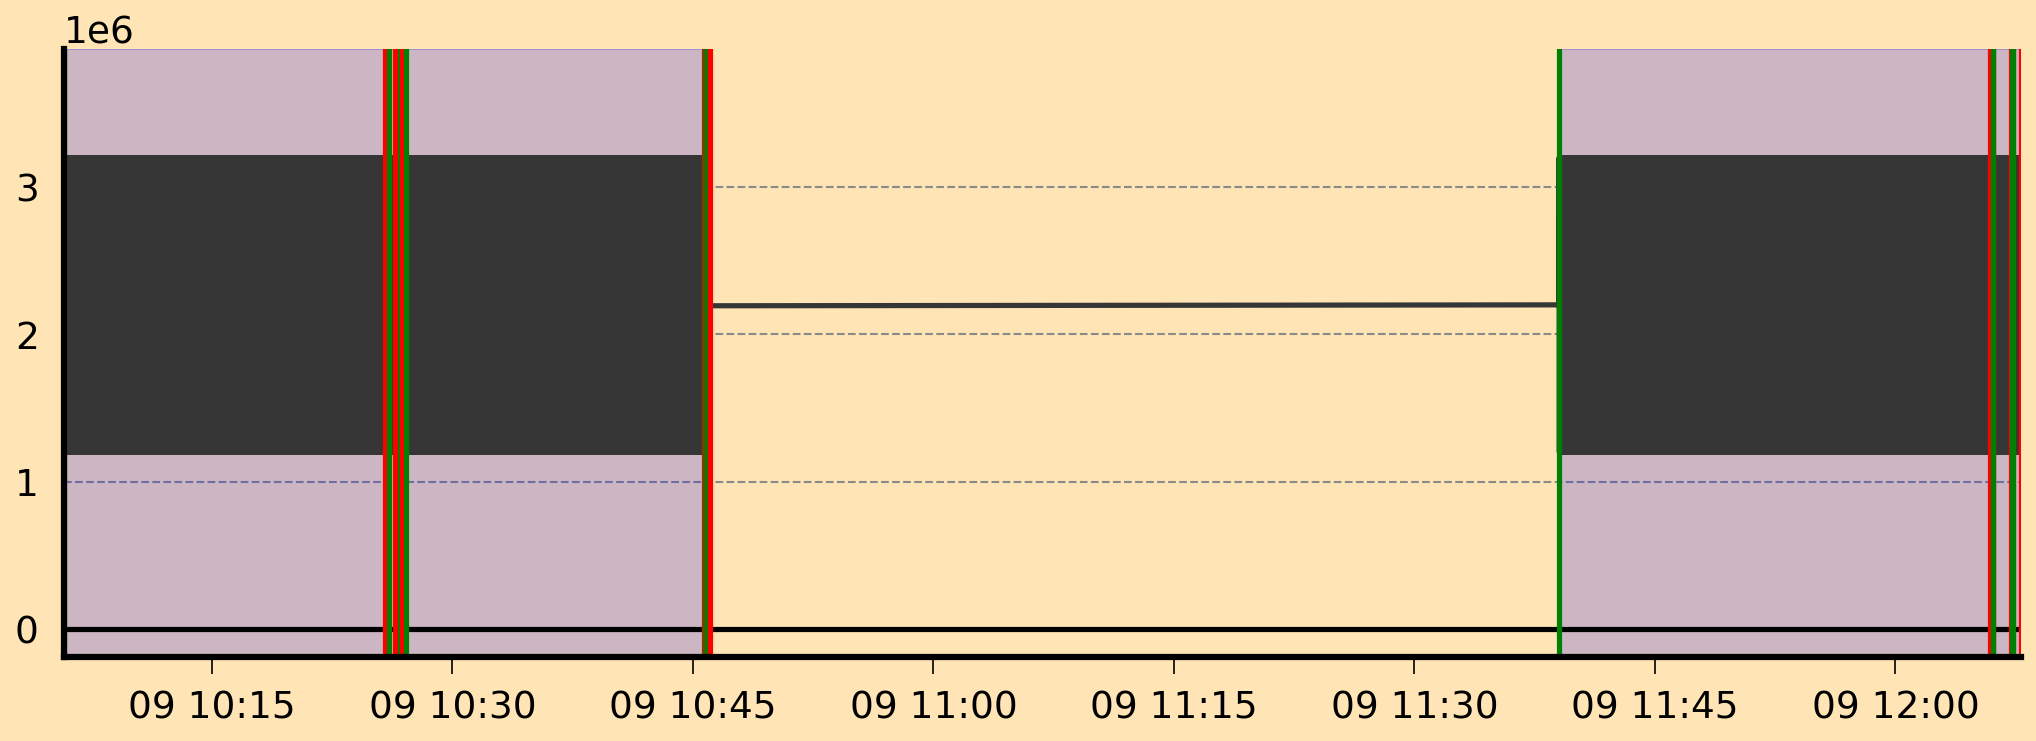

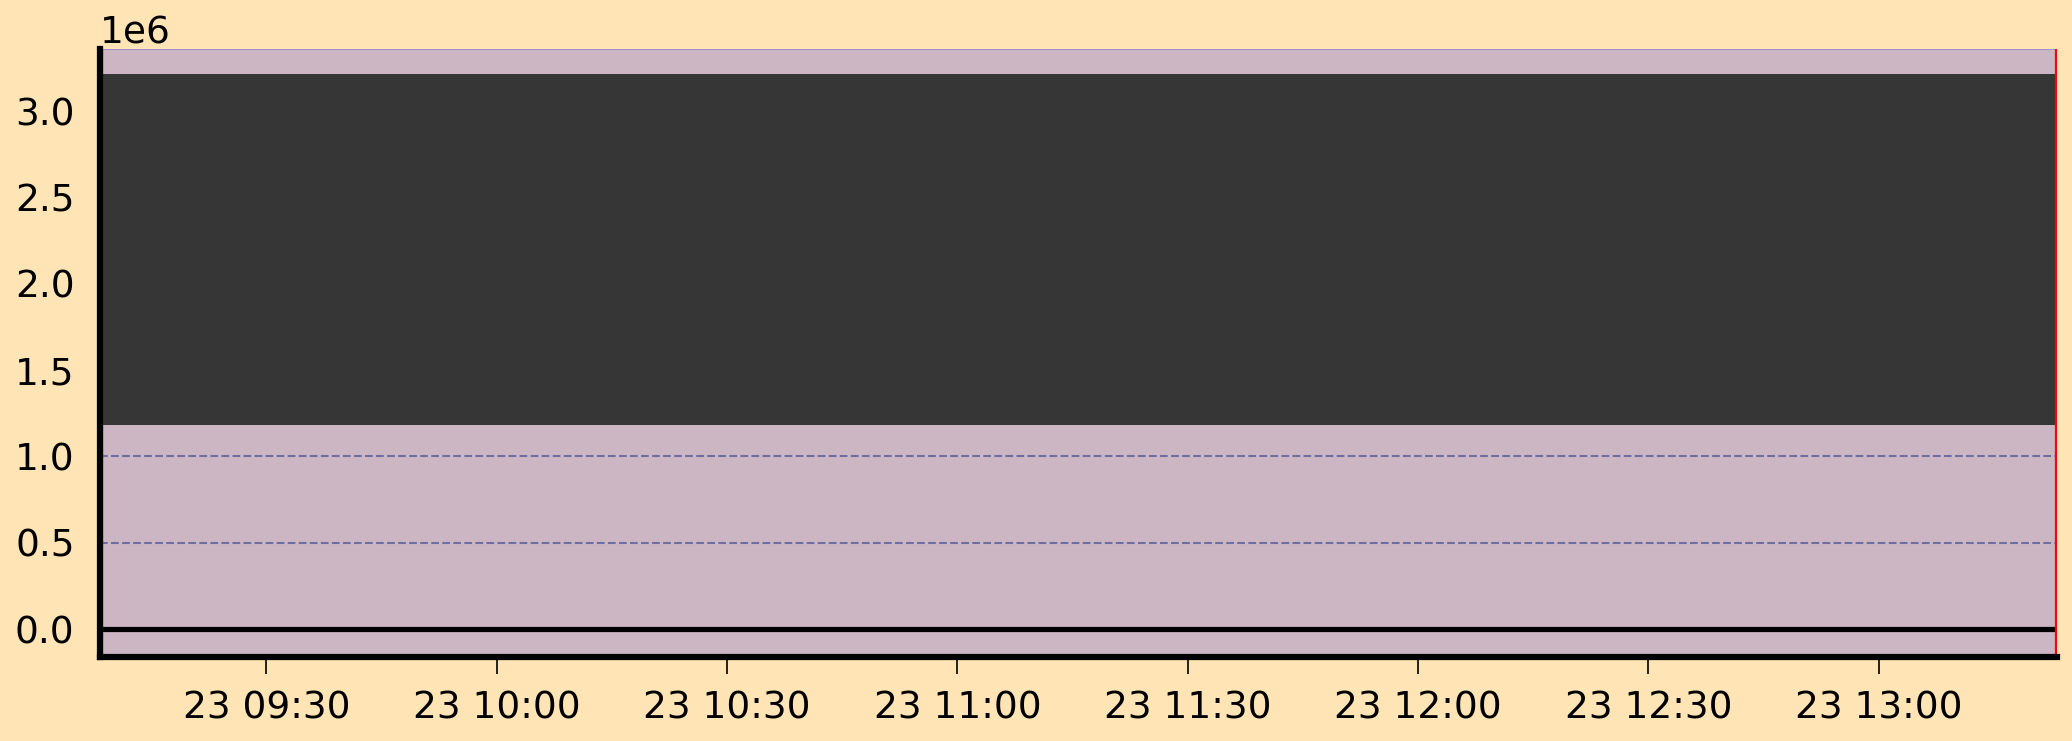

In [44]:
stims_13 = {'laser1':'Wav2', 'sdpi':'Wav2'}
stim_info_to_yaml('ACR_13', stims_13)

read from t=0s to t=50151.31s
read from t=0s to t=85787.21s
read from t=0s to t=73385.91s


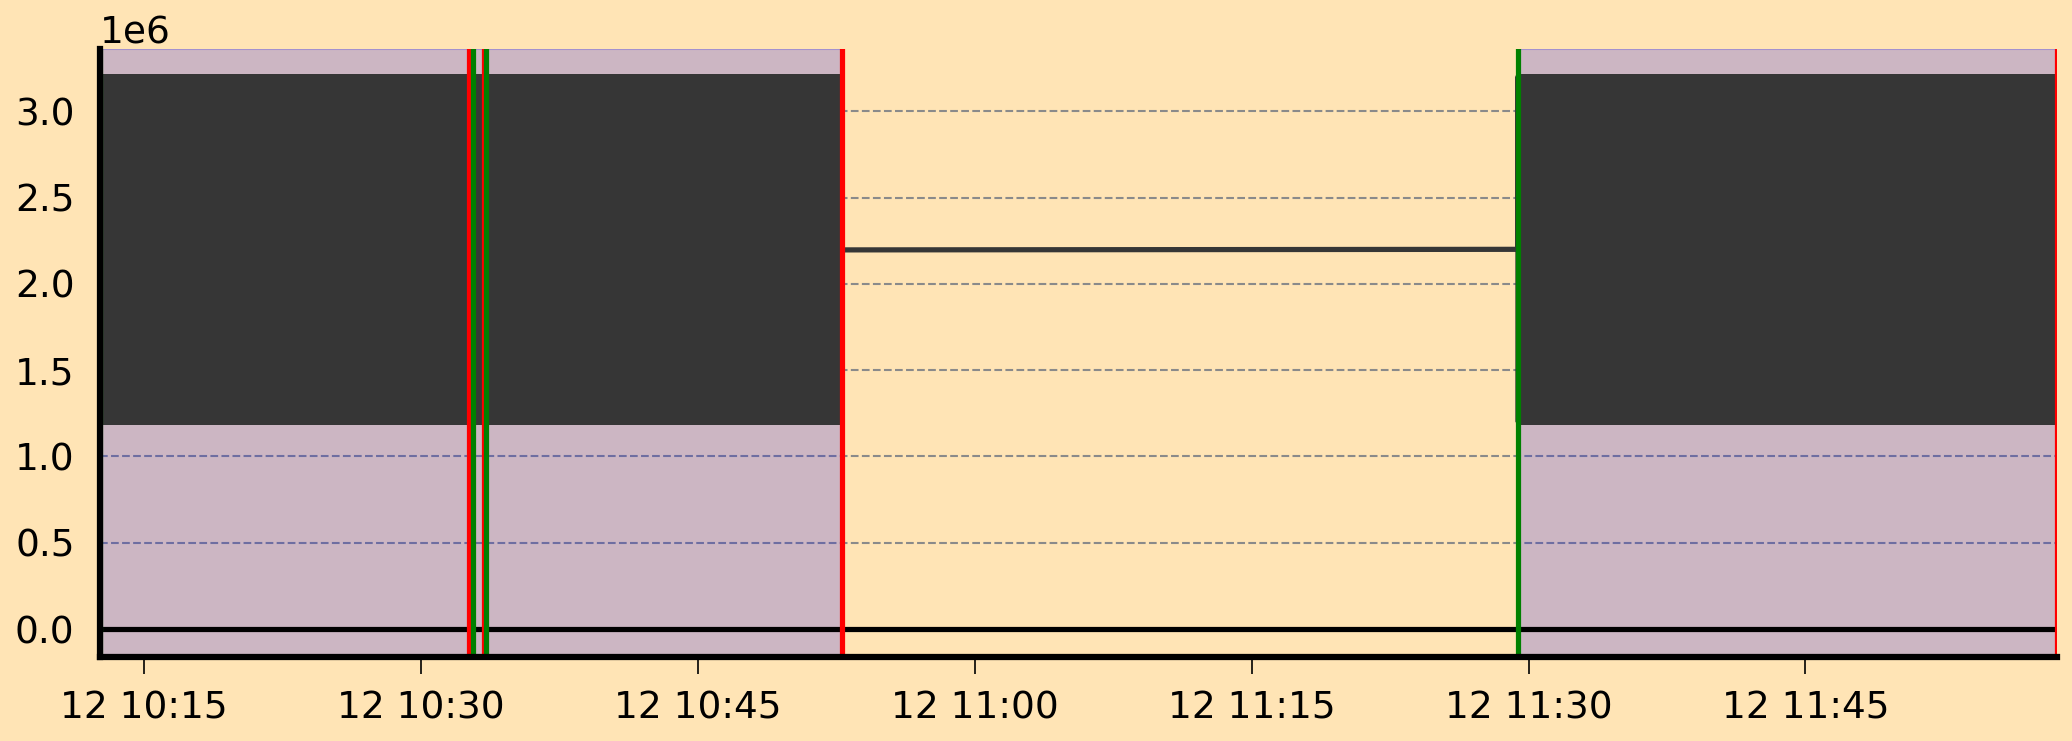

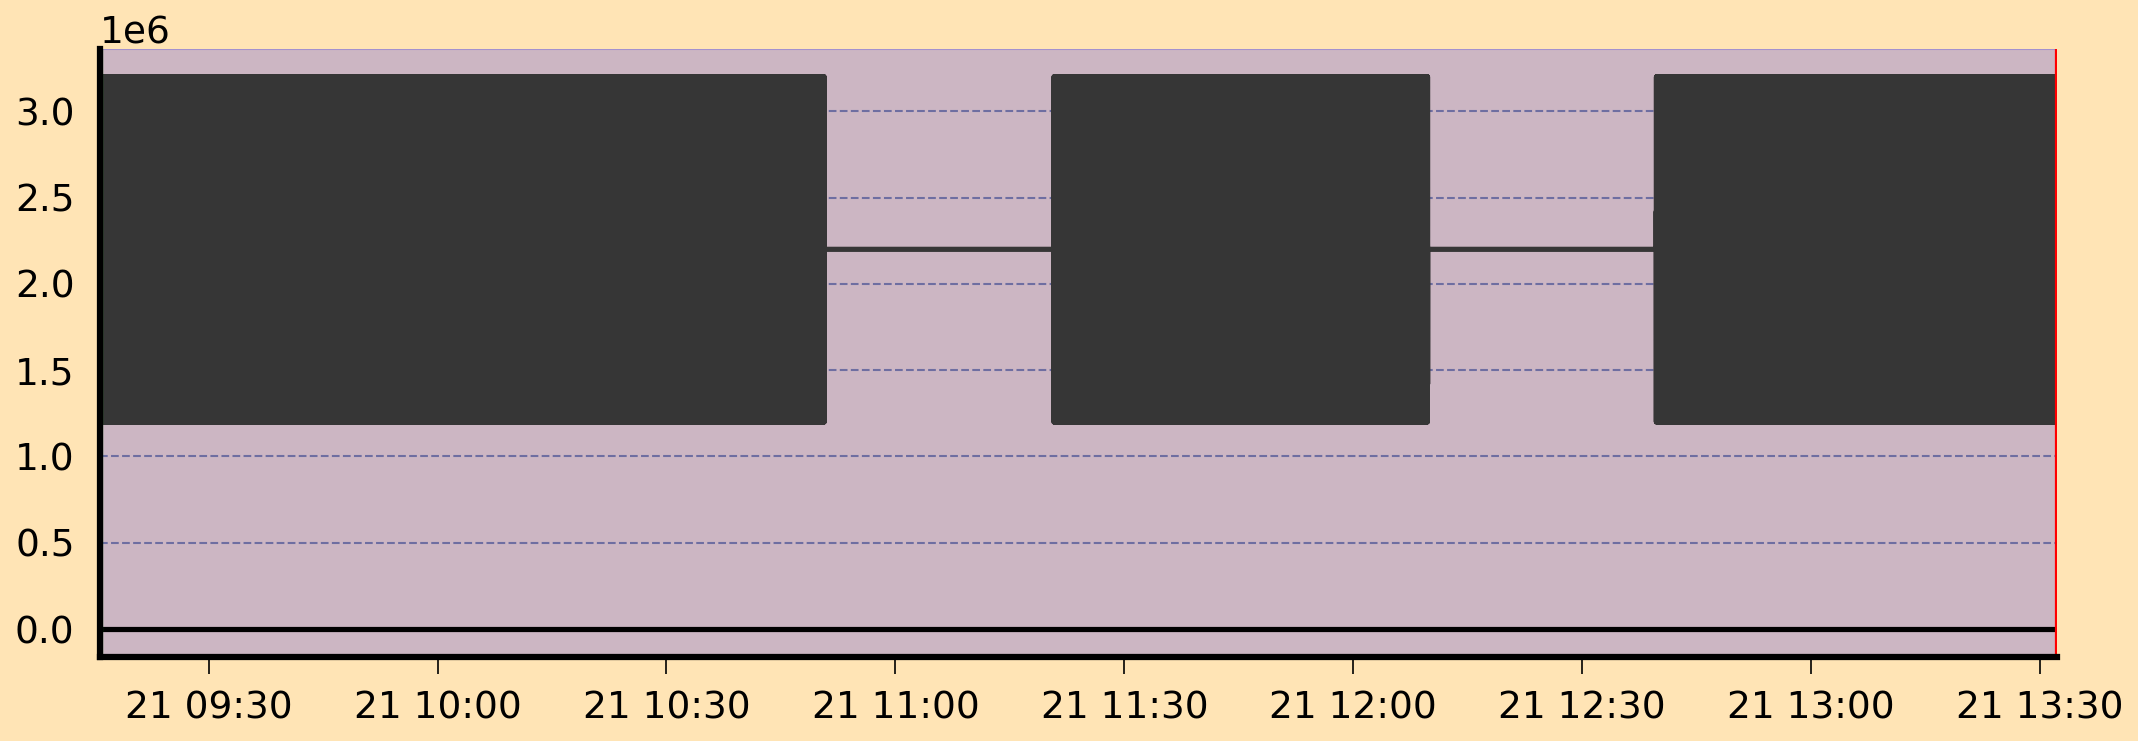

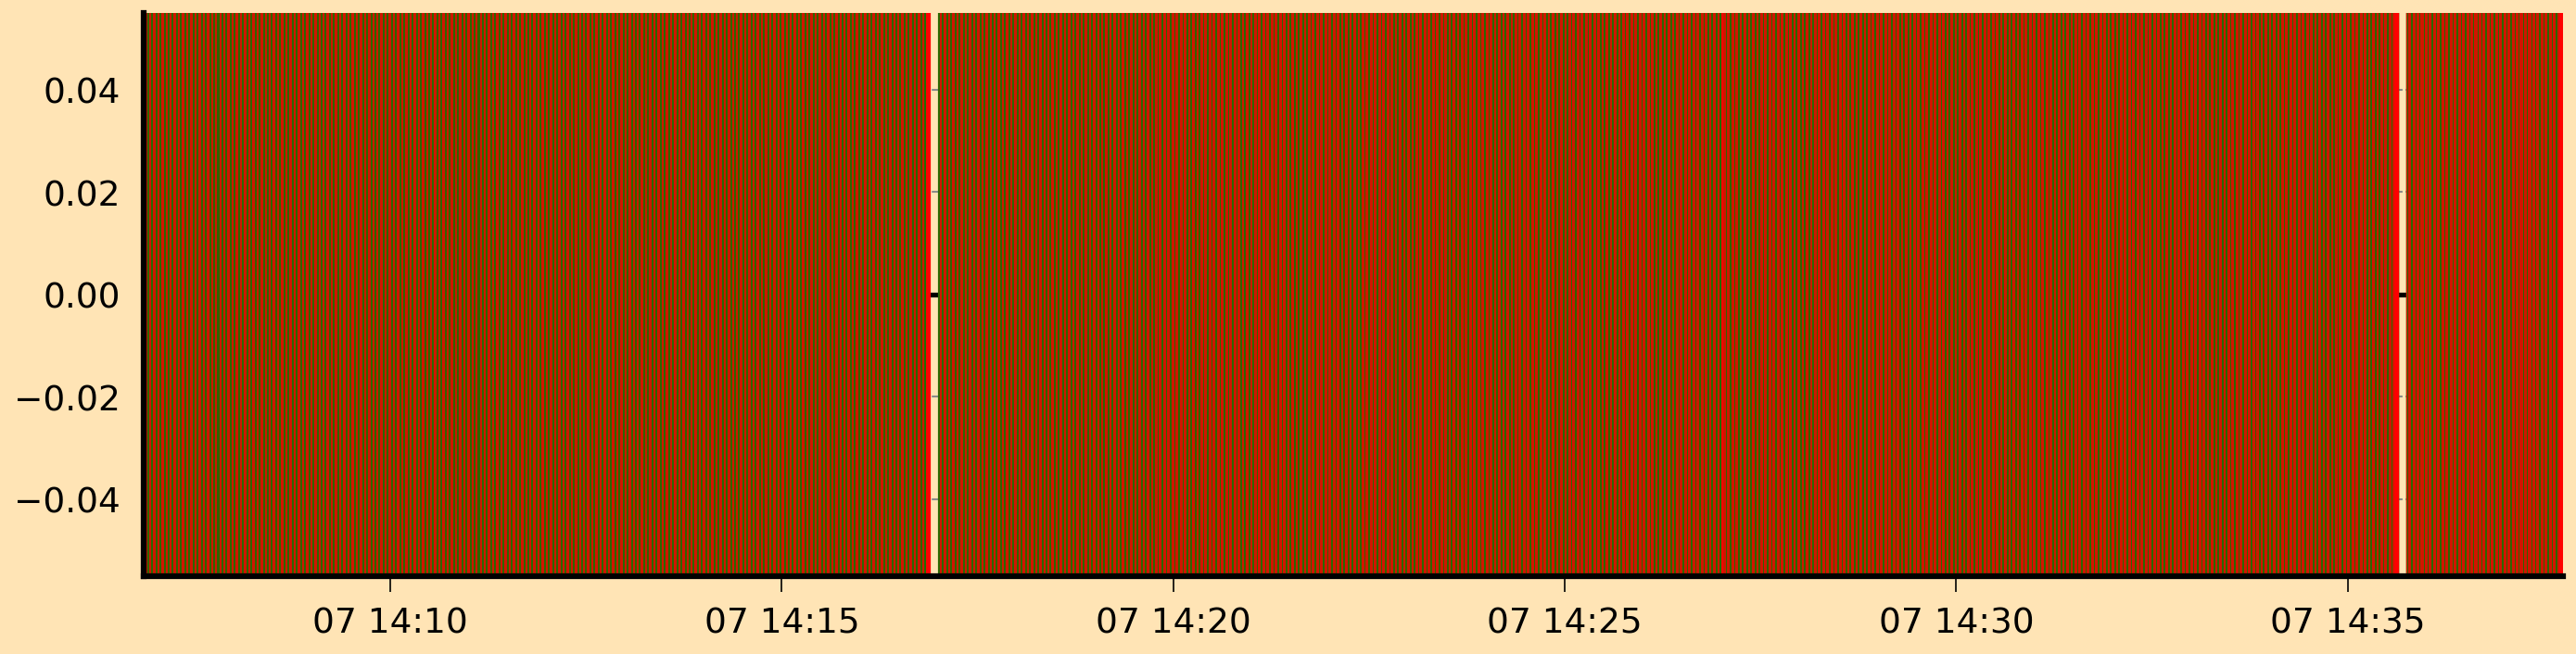

In [45]:
stims_14 = {'laser1':'Wav2', 'sdpi':'Wav2', 'swi':'Pu1_'}
stim_info_to_yaml('ACR_14', stims_14)

In [ ]:
def add_stim_mask(onsets, offsets, data, ss_freq=None, pulse_params=False, button_params=False, name='stim'):
    """ss_freq -> the frequency of the sinusiod"""
    
    mask = np.zeros_like(data.datetime.values, dtype=bool)
    for on, off in zip(onsets, offsets):
        mask |= (data.datetime.values >= on) & (data.datetime.values <= off)
    
    # add stim coordinate to the data
    data = data.assign_coords({name: ('datetime', mask)})
    if ss_freq:
        assert len(freq) == 1
        freq_id = name+'-freq'
        data = data.assign_attrs({freq_id: freq[0]})
    if pulse_params:
        on_time = (on[1] - on[0])/np.timedelta64(1, 's')
        freq = 1/on_time
    return data

In [2]:
def preprocess_and_save_exp(subject, rec, fs_target=400, t1=0, t2=0):
    """
    Preprocesses (downsample via decimate) and saves timeseries data as xarray objects.
    Takes a single experiment ID loads the relevant stores from raw_stores and saves that.
    Channels are specified in the subject_info.yml file.
    Stores to use are defined by raw_stores in the subject_info.yml file.
    """

    # Load raw data from 'preprocess-list' in subject_info.yml
    path = f"/Volumes/opto_loc/Data/ACR_PROJECT_MATERIALS/{subject}/subject_info.yml"
    with open(path) as f:
        data = yaml.load(f, Loader=yaml.FullLoader)
    raw_data = {}
    path = data["paths"][rec]
    for store in data["raw_stores"]:
        raw_data[rec + "-" + store] = kx.io.get_data(
            path, store, channel=data["channels"][store], t1=t1, t2=t2
        )

    # Decimate raw data
    dec_data = {}
    for key in raw_data.keys():
        print("decimating: " + key)
        dec_q = int(raw_data[key].fs / fs_target)
        if dec_q > 1:
            dec_data[key] = kx.utils.decimate(raw_data[key], dec_q)
        else:
            print(
                "fs_target is higher than original fs, skipping decimation for " + key
            )
            print("fs_target: " + str(fs_target))
            print("original fs: " + str(raw_data[key].fs))
            dec_data[key] = raw_data[key]
    # Save decimated data
    save_root = f"/Volumes/opto_loc/Data/{subject}/"
    for key in dec_data.keys():
        print("saving: " + key)
        save_path = save_root + key + ".nc"
        kx.io.save_dataarray(dec_data[key], save_path)
    return

In [ ]:
def preprocess_and_save_exps(subject, exp, fs_target=400, t1=0, t2=0):
    """
    Preprocesses (downsample via decimate) and saves timeseries data as xarray objects.
    Goes through all important recordings in in the subject's preprocess-list in the subject_info.yml file.
    Channels are specified in the subject_info.yml file.
    Stores to use are defined by raw_stores in the subject_info.yml file.
    """

    # Load raw data from 'preprocess-list' in subject_info.yml
    path = f"/Volumes/opto_loc/Data/ACR_PROJECT_MATERIALS/{subject}/subject_info.yml"
    with open(path) as f:
        data = yaml.load(f, Loader=yaml.FullLoader)
    raw_data = {}
    for rec in data["preprocess-list"]:
        path = data["paths"][rec]
        for store in data["raw_stores"]:
            raw_data[rec + "-" + store] = kx.io.get_data(
                path, store, channel=data["channels"][store], t1=t1, t2=t2
            )

    # Decimate raw data
    dec_data = {}
    for key in raw_data.keys():
        print("decimating: " + key)
        dec_q = int(raw_data[key].fs / fs_target)
        if dec_q > 1:
            dec_data[key] = kx.utils.decimate(raw_data[key], dec_q)
        else:
            print(
                "fs_target is higher than original fs, skipping decimation for " + key
            )
            print("fs_target: " + str(fs_target))
            print("original fs: " + str(raw_data[key].fs))
            dec_data[key] = raw_data[key]
    # Save decimated data
    save_root = f"/Volumes/opto_loc/Data/{subject}/"
    for key in dec_data.keys():
        print("saving: " + key)
        save_path = save_root + key + ".nc"
        kx.io.save_dataarray(dec_data[key], save_path)
    return

In [8]:
def prepro_lite(subject, rec, fs_target=100, t1=0, t2=0):
    """
    Preprocess and save all experiments which were not included in preprocess-list in subject_info.yml.
    """
    # Load all data that was not included in preprocess-list
    path = f"/Volumes/opto_loc/Data/ACR_PROJECT_MATERIALS/{subject}/subject_info.yml"
    with open(path) as f:
        data = yaml.load(f, Loader=yaml.FullLoader)
    raw_data = {}
    path = data["paths"][rec]
    
    try:
        for store in data["lite_stores"]:
            raw_data[rec + "-" + store] = kx.io.get_data(
                path, store, channel=data["channels"][store], t1=t1, t2=t2
            )
    except:
        print("no lite stores for " + rec)
        print("using raw_stores for " + rec)
        for store in data["raw_stores"]:
            raw_data[rec + "-" + store] = kx.io.get_data(
                path, store, channel=data["channels"][store], t1=t1, t2=t2
            )
    # Decimate the data
    dec_data = {}
    for key in raw_data.keys():
        print("decimating: " + key)
        dec_q = int(raw_data[key].fs / fs_target)
        if dec_q > 1:
            dec_data[key] = kx.utils.decimate(raw_data[key], dec_q)
        else:
            print(
                "fs_target is higher than original fs, skipping decimation for " + key
            )
            print("fs_target: " + str(fs_target))
            print("original fs: " + str(raw_data[key].fs))
            dec_data[key] = raw_data[key]

    # Save decimated data
    save_root = f"/Volumes/opto_loc/Data/{subject}/"
    for key in dec_data.keys():
        print("saving: " + key)
        save_path = save_root + key + ".nc"
        kx.io.save_dataarray(dec_data[key], save_path)
    return

In [9]:
prepro_lite("ACR_13", 'mon1', t1=0, t2=20)

read from t=0s to t=1041.55s
Using 152.5879 Hz as SEV sampling rate for EEG_
read from t=0s to t=1041.55s
Using 1017.2526 Hz as SEV sampling rate for EMGr
read from t=0s to t=1041.55s
Using 305.1758 Hz as SEV sampling rate for LFP_
read from t=0s to t=1041.55s
Using 305.1758 Hz as SEV sampling rate for LFPo
decimating: mon1-EEG_
fs_target is higher than original fs, skipping decimation for mon1-EEG_
fs_target: 100
original fs: 152.587891
decimating: mon1-EMGr
decimating: mon1-LFP_
decimating: mon1-LFPo
saving: mon1-EEG_
saving: mon1-EMGr
saving: mon1-LFP_
saving: mon1-LFPo
